## Exploring NC files
Updated to use functions and read-files



In [1]:
# ---Packages---
import cartopy.crs as ccrs
#import hvplot.xarray
import xarray as xr
import cartopy.feature as cfeature
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import warnings
import shapely.geometry as sgeom

import functions
import read_nav

# removes warnings. Using np.datetime64() gives an outdated Deprecation warning.
# to see warnings once use warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# --- Global formatting/settings/variables

# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

# colors for flights (to use all the same colors!
c_flights = {'IS22-01':'wheat',
              'IS22-02':'tab:green',
              'IS22-03':'tab:red',
              'IS22-04':'tab:purple',
              'IS22-05':'tab:blue',
              'IS22-06':'tab:brown',
              'IS22-07':'tab:gray',
              'IS22-08':'tab:olive',
              'IS22-09':'tab:cyan',
              'IS22-10':'tab:pink',
              'IS22-11':'tab:orange'}

In [3]:
# ---Data---
# Based on scripts in files read_*.py

# Navigational data
# -- nav_df: data variables
# -- nav_stats_dict: statistics for each flight
nav_df, nav_stats_dict = read_nav.read_nav()

In [4]:
# ---Statistical overview of the flights----
# collect information for displaying for all flights:
# Directly from attributes
# - flight id, takeoff, landing
# Calculated:
# - time in air (takeoff, landing)
# - max/min temp (TAS1/TAS2) (in cloud or just in total?)

In [5]:
# --- Map initialization ---
#-- Map initialization based on flight info --

# Find the max and min lat and lon in the dataset
inc = 1
lat_max = nav_df['Latitude (degree)'].max() + inc
lat_min = nav_df['Latitude (degree)'].min() - inc
lon_max = nav_df['Longitude (degree)'].max() + inc
lon_min = nav_df['Longitude (degree)'].min() - inc

# coordinates of Andøya
#lat_and = 69.3073
#lon_and = 16.1312

# coordinates of Kiruna
lat_kir = 67.8256
lon_kir = 20.3351


In [6]:
# ---- Plot coordinates -----
# Plotting lat and lon on map
def plot_map(nav_df, flight = "", file_str = ""):
    # Function to create a map showing the flight paths. Uses set colors and area to plot in. 
    # INPUT arguments:
    #   nav_df: dataframe that contains at least the two columns: 'Longitude (degree)' and 'Latitude (degree)'
    # OPTIONAL INPUT arguments:
    #   flight: name of single flight to plot. If no flight is added, all flights are plotted.
    #   file_str: name of file to print plot to. If no file string is added, the plot is not saved.
    # Additional information:
    #   Uses global variable: c_flights

    #-- Map initialization based on flight info --

    # Find the max and min lat and lon in the dataset
    inc = 1
    lat_max = nav_df['Latitude (degree)'].max() + inc
    lat_min = nav_df['Latitude (degree)'].min() - inc
    lon_max = nav_df['Longitude (degree)'].max() + inc
    lon_min = nav_df['Longitude (degree)'].min() - inc
    
    # coordinates of Andøya
    #lat_and = 69.3073
    #lon_and = 16.1312
    
    # coordinates of Kiruna
    lat_kir = 67.8256
    lon_kir = 20.3351

    # --- Set up figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()
    
    if flight == "":
        # plot all the flights from ISLAS if "flight" is empty
        for flight in nav_df['flightid'].unique().sort_values():
            sel_df = nav_df[nav_df['flightid']==flight] # filtrate on flight
            date = sel_df.index[0].date() # get the date of the flight
            ax.plot(sel_df['Longitude (degree)'], sel_df['Latitude (degree)'],
                label = f'{flight} ({date})', c =c_flights[flight], transform = data_projection)
    else:
        # Plot only the given flight if "flight" contains a flightid
        try:
            sel_df = nav_df[nav_df['flightid']==flight] # filtrate on flight
            date = sel_df.index[0].date() # get the date of the flight
            ax.plot(sel_df['Longitude (degree)'], sel_df['Latitude (degree)'],
                    label = f'{flight} ({date})', c =c_flights[flight], transform = data_projection)
        except ValueError:
            print(f'Flightid: {flight} is not a valid flightid. Needs to be in the format "IS22-XX" where X is a number between 02 and 11')
     
    
    #Plot Andøya on map
    #ax.plot(lon_and, lat_and, marker='o', color='tab:red', transform=data_projection)
    #ax.annotate('Andøya', (lon_and, lat_and))
    
    #Plot Kiruna on map
    ax.plot(lon_kir, lat_kir, marker='o', color='tab:red', transform=data_projection)
    #Add text "Kiruna" at the plotted point
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')
    
    
    # --- Drawing a dashed box
    #lons = [16, 22, 22, 16, 16]
    #lats = [74, 74, 76, 76, 74]
    #ax.plot(lons, lats, linestyle='--', color='black', transform=ccrs.PlateCarree())
    # ---
    
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    plt.legend(loc='best')
    
    # save figure if filestring is given
    if file_str !="":
        plt.savefig(file_str) 


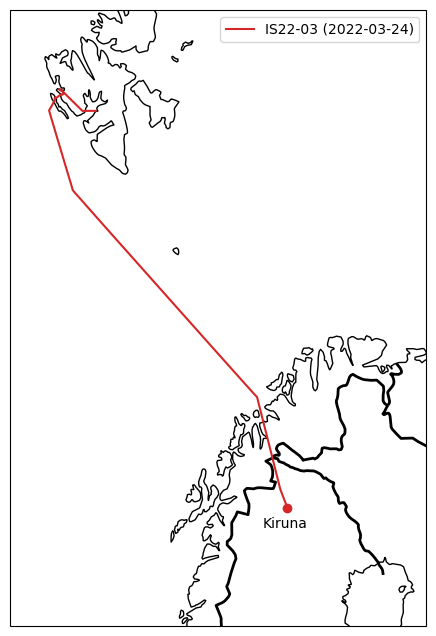

In [9]:
plot_map(nav_df, flight='IS22-03')

## Preprocessing NAV data
Creating TAS file to use for correction of the CIP data in SODA2

In [ ]:
# --- creating TAS file for SODA2 processing ---

# loop over all the datastructures in ds_list (ds5-ds15)
for ds in ds_list:
    # Create TAS files using TAS1:TAS from Scientific Static/Pitot system
    # Alternative is TAS2:TAS from Avionic Static/Pitot system (ADC)
    TAS = ds.TAS1
    flight_id = ds.attrs['flight_id'] # extract flightid for use in filename
    
    # converts the TAS xarray to dataframe with time, LATITUDE, LONGITUDE, ALTITUDE and TAS1 as columns
    # this conversion is done to simplify the creating of the csv file
    tas_df = TAS.to_dataframe()
    tas_df = tas_df.drop(['LATITUDE','LONGITUDE','ALTITUDE'], axis =1) #Need only TAS1

    # add time as a separate column to simplify time manipulation
    tas_df['time'] = tas_df.index

    # recalculate time from datetime to seconds since midnight (func)
    tas_df['time'] = tas_df['time'].apply(sec_since_midnigth)

    # rearrange columns to get correct structure for use in SODA2
    tas_df = tas_df.reindex(columns=['time','TAS1'])
    # set TAS as integer
    tas_df['TAS1']=tas_df['TAS1'].astype(int)

    # create filename, format: TAS_fightid.csv  (TAS_as220005.csv)
    # filepath to results folder
    path_out = 'Results_2022-islas/' + flight_id + '/'
    filename = path_out +'TAS_' + flight_id + '.csv'

    # print tdf to csv-file to be used in SODA2, 
    # change headers to what SODA2 reads,
    # do not add index as correct timeformat is already in column time
    # make sure that it is encoded as ascii
    tas_df.to_csv(filename, header=['time','tas'], encoding='ascii', index=False)
